In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score

from utils import get_x_y, stratified_split
from preprocessing import preprocess_df

In [32]:
model_name = "distilbert-base-uncased"
MAX_SEQ_LEN = 128
num_labels = 2

params_dict = {'learning_rate': 1e-5,
                'epochs': 3,
                'batch': 16,
                }

In [33]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [34]:
# split data
train_set, valid_set, test_set = stratified_split(df)
# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

x_train = x_train.values.tolist()
x_test = x_test.values.tolist()
x_valid = x_valid.values.tolist()

In [35]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
tokenized_train = tokenizer(x_train, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')
tokenized_valid = tokenizer(x_valid, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')
tokenized_test = tokenizer(x_test, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')

In [37]:
for key in tokenized_train:
    print(key)

input_ids
attention_mask


In [38]:
# Build the DistilBERT model for sequence classification
distilbert = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [39]:
input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = distilbert(input_ids, attention_mask=mask)[0]

y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(embeddings)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_for_sequenc  TFSequenceClassifierOutput   6695501   ['input_ids[0][0]',           
 e_classification_1 (TFDist  (loss=None, logits=(None,    0          'attention_mask[0][0]']      
 ilBertForSequenceClassific  2),                                                            

In [40]:
optimizer =  Adam(learning_rate=params_dict['learning_rate'])
loss = BinaryCrossentropy()
acc = BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [41]:
# Train the model
history = model.fit((tokenized_train['input_ids'], tokenized_train['attention_mask']), 
                    y_train,
                    validation_data=((tokenized_valid['input_ids'], tokenized_valid['attention_mask']), y_valid),
                    epochs=params_dict['epochs'], 
                    batch_size=params_dict['batch'])

model.save('models/' + model_name + '.h5')

Epoch 1/3


5625/5625 [==============================] - 4474s 794ms/step - loss: 0.1220 - accuracy: 0.9525 - val_loss: 0.0628 - val_accuracy: 0.9764
Epoch 2/3
5625/5625 [==============================] - 4427s 787ms/step - loss: 0.0366 - accuracy: 0.9867 - val_loss: 0.1600 - val_accuracy: 0.9434
Epoch 3/3
5625/5625 [==============================] - 4433s 788ms/step - loss: 0.0163 - accuracy: 0.9942 - val_loss: 0.0890 - val_accuracy: 0.9720


/home/mfain/anaconda/envs/roberta-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
def get_predictions(model, tokenized_x_test):
    predictions = model.predict(dict(tokenized_x_test))
    predictions = np.where(predictions.max(axis=-1) > 0.5, 1, 0)
    return predictions

def acc_loss(history):
    # Visualize Loss & Accuracy

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(np.array(y_true), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def roc_score(model_name, y_true, y_pred_proba):
    """
    Plots the ROC curve for the given model and data. Calculates and prints the area under the ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    print(f'AUC: {auc}')
    plt.plot(fpr, tpr, label=model_name+" AUC="+str(round(auc, 3)))
    plt.legend(loc='best')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve for {model_name}')
    plt.show()

def validate_model_distilbert(distilbert, history, tokenized_x_test, y_true):
    print('#### VALIDATION ####')
    acc_loss(history)

    predictions_proba = distilbert.predict(dict(tokenized_x_test))
    y_pred = np.where(predictions_proba.max(axis=-1) > 0.5, 1, 0)
    print('Classification report:')
    print(classification_report(y_true, y_pred, zero_division=0))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1-score: ', f1_score(y_test, y_pred))

    conf_matrix(y_true, y_pred)
    roc_score('DistilBERT', y_test, predictions_proba.flatten())

#### VALIDATION ####


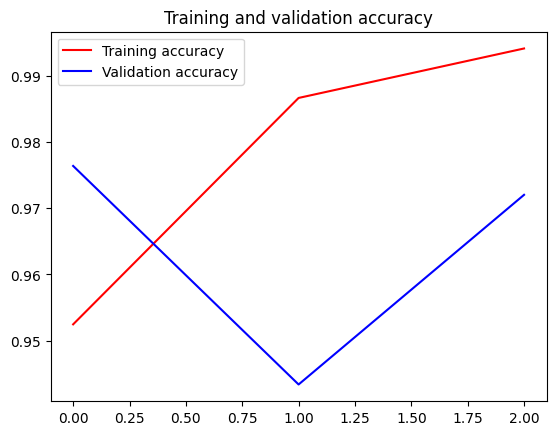

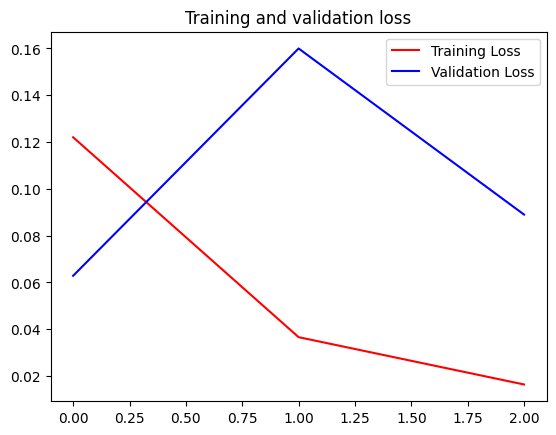

110/938 [==>...........................] - ETA: 6:20

938/938 [==============================] - 433s 460ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     15000
           1       0.95      1.00      0.97     15000

    accuracy                           0.97     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.97      0.97      0.97     30000

Accuracy:  0.9699666666666666
Recall:  0.9952
F1-score:  0.9707058555775921


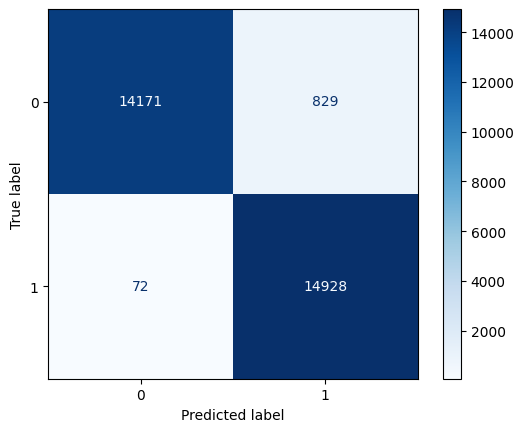

AUC: 0.9988983311111111


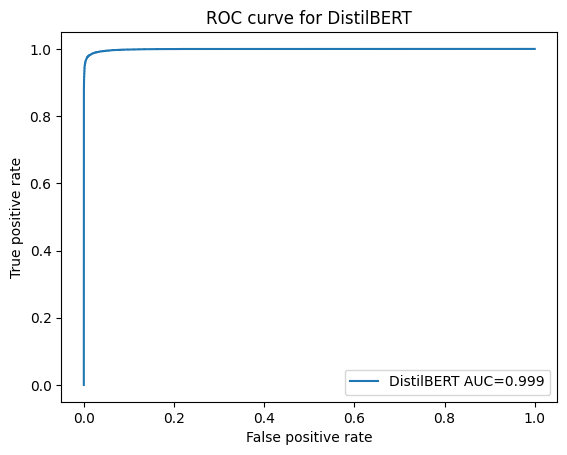

In [43]:
validate_model_distilbert(model, history, tokenized_test, y_test)

# Predicting on New Data

In [44]:
def get_extra_data(path):
    #load to df
    data = pd.read_pickle(path)
    data = pd.DataFrame({'text': data})
    # add labels
    labels = np.ones(data.shape[0])
    data['generated'] = labels
    return data

In [45]:
def validate_predictions_distilbert(distilbert, tokenized_x_test, y_true):
    print('#### VALIDATION ####')

    y_pred = get_predictions(distilbert, tokenized_x_test)
    print('Classification report:')
    print(classification_report(y_true, y_pred, zero_division=0))

    conf_matrix(y_true, y_pred)

In [46]:
def predict_data(model, tokenizer, data):
    # prepare data
    data = preprocess_df(data)
    x = data['preprocessed_text'].values.tolist()
    tokenized_x = tokenizer(x, max_length=MAX_SEQ_LEN, padding=True, truncation=True, return_tensors='tf')
    y = np.array(data['generated'])
    
    validate_predictions_distilbert(model, tokenized_x, y)

#### VALIDATION ####
44/44 [==============================] - 20s 453ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      1375
           1       0.01      0.67      0.02         3

    accuracy                           0.81      1378
   macro avg       0.50      0.74      0.46      1378
weighted avg       1.00      0.81      0.90      1378



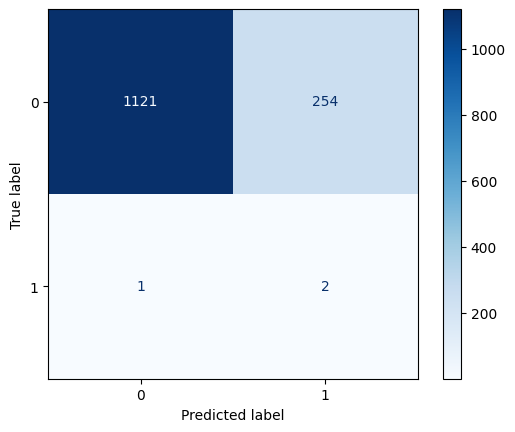

In [48]:
df_essays = pd.read_csv('data/extras/train_essays.csv', header=0)
predict_data(model, tokenizer, df_essays)

In [49]:
df_palm = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


#### VALIDATION ####
113/113 [==============================] - 51s 451ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.87      0.93      3611

    accuracy                           0.87      3611
   macro avg       0.50      0.43      0.47      3611
weighted avg       1.00      0.87      0.93      3611



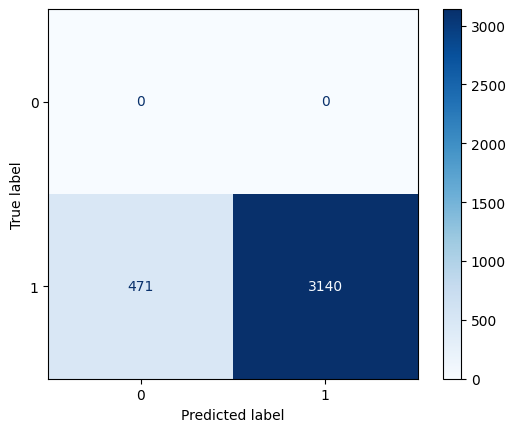

In [50]:
predict_data(model, tokenizer, df_extras)